In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
import requests
import os
import json
import plotly.express as px
from shapely.geometry import Polygon
from shapely import wkt
import geopandas as gpd
import itertools
import random

In [18]:
data = pd.read_csv('../data/crimes.csv')

In [69]:
if not os.path.exists('../data/osm'):
    os.makedirs('../data/osm')
if not os.path.exists('../data/polys'):
    os.makedirs('../data/polys')

def filename(county_name):
    return "%20".join(county_name.split(sep=' ')[:-1])

osm_data = dict()
for n in data['name']:
    success = False
    while (not success):
        first_part = filename(n)
        cache_file = Path('../data/osm/' + first_part)
        if cache_file.is_file():
            osm_data[first_part] = cache_file.read_text("utf-8")
            success = True
            break
        cache_file.open("w")
        request_uri = 'http://www.overpass-api.de/api/interpreter?data=[out:json];relation[%22boundary%22=%22administrative%22][%22admin_level%22=%226%22][%22nist:state_fips%22=%2237%22][%22name%22=%22'+first_part+'%20County%22];out%20geom;'
        response = requests.get(request_uri)
        success = response.status_code == 200
        cache_file.write_text(response.text, "utf-8")
polygon_data = dict()
for key in osm_data:
    sucess = False
    while not sucess:
        cache_file = Path('../data/polys/' + key)
        if cache_file.is_file():
            polygon_data[key] = wkt.loads(cache_file.read_text("utf-8"))
            success = True
            break
        json_data = json.loads(osm_data[key])
        id = json_data['elements'][0]['id']
        request_uri = 'http://polygons.openstreetmap.fr/get_wkt.py?id='+str(id)+'&params=0'
        response = requests.get(request_uri)
        sucess = response.status_code == 200
        poly_text = ";".join(response.text.split(';')[1:])
        cache_file.write_text(poly_text, "utf-8")
        polygon_data[key] = wkt.loads(poly_text)

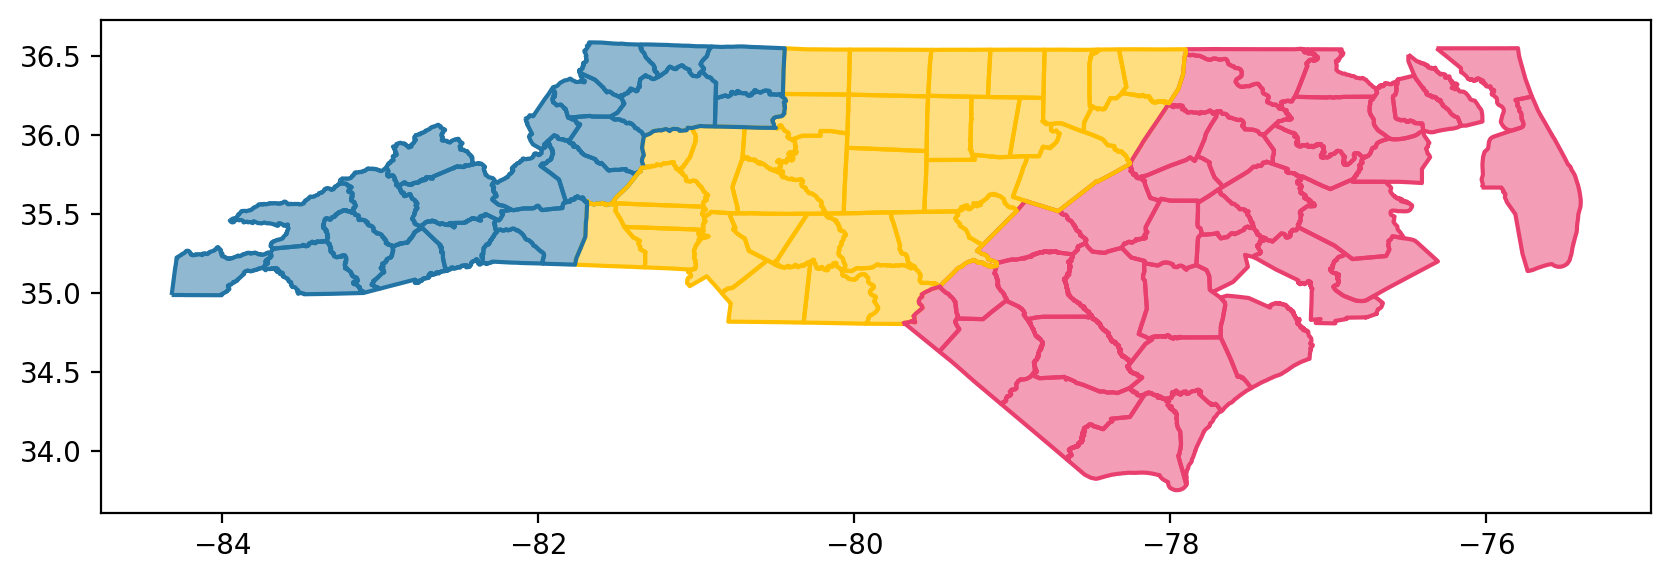

In [87]:
region_color = {
    'central': '#FFBF00',
    'other': '#E83F6F',
    'west': '#2274A5'
}

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(1,1)
for index,row in data.iterrows():
    identifier = filename(str(row['name']))
    gpd.GeoSeries(polygon_data[identifier]).boundary.plot(ax= ax, alpha=1, color=region_color[row['region']],zorder=3)
    gpd.GeoSeries(polygon_data[identifier]).plot(ax= ax, alpha=0.5, color=region_color[row['region']],zorder=2)